In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import anndata as ad
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

/opt/anaconda3/envs/scvi-env-arm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Cell_tagMulti = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cellTag_test_multi_Seurat_clone_id.h5ad"
Cell_tag = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cellTag_train_tag_Seurat.h5ad"

Cell_tagMulti = ad.read_h5ad(Cell_tagMulti)
Cell_tag = ad.read_h5ad(Cell_tag)

adata_Cell_Multi_labels = Cell_tagMulti.obs["clone_id"].to_numpy()  # keep user’s dtype; NaN ok
adata_Cell_tag_labels  = Cell_tag.obs["clone_id"].to_numpy()

In [3]:
def lineage_size_stats(labels):
    """
    Compute mean, median, min, max, and std of lineage (clone_id) sizes.
    Assumes all cells are labeled.
    """
    sizes = pd.Series(labels).value_counts()
    stats = {
        "mean":   sizes.mean(),
        "median": sizes.median(),
        "min":    sizes.min(),
        "max":    sizes.max(),
        "std":    sizes.std()
    }
    return pd.Series(stats, name="lineage_size_stats")

In [4]:
len(adata_Cell_tag_labels)

6534

In [5]:
lineage_size_stats(adata_Cell_tag_labels)

mean        38.662722
median      10.000000
min          5.000000
max       1309.000000
std        122.235861
Name: lineage_size_stats, dtype: float64

### load proj head embedding

In [6]:
embed_path = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Cell_tag-Cell_tag_multi"

train_001_5 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab5_bs250_testAsPenalty/train_proj_embed.npy")
train_001_15 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab15_bs250_testAsPenalty/train_proj_embed.npy")
train_001_25 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_001_50 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab50_bs250_testAsPenalty/train_proj_embed.npy")
train_005_50 = np.load(embed_path + "/feat_celltagMulti_lambda005_unlab50_bs250_testAsPenalty/train_proj_embed.npy")


train_01_25 = np.load(embed_path + "/feat_celltagMulti_lambda0.1_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_1_25 = np.load(embed_path + "/feat_celltagMulti_lambda1_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_2_25 = np.load(embed_path + "/feat_celltagMulti_lambda2_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_10_25 = np.load(embed_path + "/feat_celltagMulti_lambda10_unlab25_bs250_testAsPenalty/train_proj_embed.npy")


test_001_5 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab5_bs250_testAsPenalty/test_proj_embed.npy")
test_001_15 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab15_bs250_testAsPenalty/test_proj_embed.npy")
test_001_25 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_001_50 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab50_bs250_testAsPenalty/test_proj_embed.npy")
test_005_50 = np.load(embed_path + "/feat_celltagMulti_lambda005_unlab50_bs250_testAsPenalty/test_proj_embed.npy")

test_01_25 = np.load(embed_path + "/feat_celltagMulti_lambda0.1_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_1_25 = np.load(embed_path + "/feat_celltagMulti_lambda1_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_2_25 = np.load(embed_path + "/feat_celltagMulti_lambda2_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_10_25 = np.load(embed_path + "/feat_celltagMulti_lambda10_unlab25_bs250_testAsPenalty/test_proj_embed.npy")

In [7]:
adata_Cell_Multi_labels = Cell_tagMulti.obs["clone_id"].to_numpy()  # keep user’s dtype; NaN ok
adata_Cell_tag_labels  = Cell_tag.obs["clone_id"].to_numpy()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import umap

def umap_embed_train_test(train_emb, test_emb, n_neighbors=15, min_dist=0.3, random_state=42):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    
    Returns:
        emb2d_train: UMAP coords for train samples
        emb2d_test:  UMAP coords for test samples
    """
    # 1) Combine embeddings
    emb_combined = np.vstack([train_emb, test_emb])

    # 2) Create labels
    split_labels = np.array(
        ["train"] * train_emb.shape[0] + ["test"] * test_emb.shape[0]
    )

    # 3) Run UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='euclidean',
        random_state=random_state
    )
    emb2d = reducer.fit_transform(emb_combined)

    # 4) Split back into train/test coords
    n_train = train_emb.shape[0]
    emb2d_train = emb2d[:n_train]
    emb2d_test  = emb2d[n_train:]

    return emb2d_train, emb2d_test
def plot_train_test_umap(emb2d_train, emb2d_test):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    """
    
    # 4) Plot — plot 'test' first, then 'train'
    plt.figure(figsize=(7, 6))

    plt.scatter(
        emb2d_train[:, 0], emb2d_train[:, 1],
        c="tab:blue", label="train", s=8, alpha=0.3
    )
    plt.scatter(
        emb2d_test[:, 0], emb2d_test[:, 1],
        c="tab:orange", label="test", s=8, alpha=0.8
    )

    plt.title("UMAP — Train on Top of Test")
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.5, frameon=True)
    plt.tight_layout()
    plt.show()
def plot_top5_umap(emb2d, labels, title):
    """
    emb: np.ndarray (n_cells, n_features) – your high-dim embeddings
    labels: 1D array-like of clone_id (ints or floats; NaN/-1 treated as 'other')
    """
    labels = pd.Series(labels).copy()

    # Treat missing as 'other'
    # If you already use -1 for unlabeled, this preserves it.
    labels_clean = labels.copy()
    labels_clean = labels_clean.where(~labels_clean.isna(), -1)

    # Top-5 clone_ids by count, excluding unlabeled (-1)
    top_ids = (
        labels_clean[labels_clean != -1]
        .value_counts()
        .head(5)
        .index.tolist()
    )
    
    # Masks
    is_top = labels_clean.isin(top_ids)
    is_other = ~is_top

    # Plot
    plt.figure(figsize=(7, 6))
    # Background first: gray
    plt.scatter(
        emb2d[is_other, 0], emb2d[is_other, 1],
        c="lightgray", s=6, alpha=0.5, linewidths=0, label="other"
    )

    # Use default matplotlib color cycle for the 5 groups
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, cid in enumerate(top_ids):
        mask = labels_clean == cid
        plt.scatter(
            emb2d[mask, 0], emb2d[mask, 1],
            s=10, alpha=0.9, linewidths=0,
            label=f"clone_id {cid}",
            c=color_cycle[i % len(color_cycle)]
        )

    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.2, frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

In [9]:
# ---------- 1) Calinski–Harabasz on test ----------
def calinski_on_test(test_emb: np.ndarray, labels) -> float:
    """
    Calinski–Harabasz index on labeled test cells.
    Assumes labels align with rows of test_emb.
    """
    # encode labels to integers (stable order)
    codes, _ = pd.factorize(pd.Series(labels), sort=True)
    if np.unique(codes).size < 2:
        raise ValueError("Need at least 2 unique lineages for CH score.")
    return calinski_harabasz_score(test_emb, codes)

# ---------- 2) Size-normalized KNN enrichment ----------
def knn_lineage_enrichment(
    test_emb: np.ndarray,
    labels,
    K: int = 50,
    metric: str = "cosine",
    return_details: bool = False,
):
    """
    For each cell i:
      p_local  = (# same-lineage among K NN) / K
      p_global = (lineage_size_i - 1) / (N - 1)
      enrichment_i = p_local / p_global
    Returns mean & median enrichment (and details if requested).
    """
    N = test_emb.shape[0]
    labels = pd.Series(labels)
    codes, uniques = pd.factorize(labels, sort=True)  # 0..L-1
    if K >= N: K = N - 1

    # KNN over all cells; first neighbor is self
    nn = NearestNeighbors(n_neighbors=K + 1, metric=metric)
    nn.fit(test_emb)
    _, nbrs = nn.kneighbors(test_emb, return_distance=True)
    nbrs = nbrs[:, 1:]  # drop self

    # global lineage sizes (counts)
    lineage_sizes = pd.Series(codes).value_counts().to_dict()

    same_in_K = np.zeros(N, dtype=int)
    enrich = np.empty(N, dtype=float)

    for i in range(N):
        yi = codes[i]
        kn_codes = codes[nbrs[i]]
        same = np.sum(kn_codes == yi)
        same_in_K[i] = same

        n_L = lineage_sizes[yi] - 1  # exclude self
        p_global = n_L / (N - 1) if N > 1 else 0.0
        p_local = same / K
        enrich[i] = (p_local / p_global) if p_global > 0 else np.nan

    mean_enrichment = np.nanmean(enrich)
    median_enrichment = np.nanmedian(enrich)

    if not return_details:
        return mean_enrichment, median_enrichment

    per_cell = pd.DataFrame({
        "cell_index": np.arange(N),
        "lineage_code": codes,
        "lineage_label": uniques[codes],
        "same_in_K": same_in_K,
        "enrichment": enrich
    })
    per_lineage = (per_cell.groupby("lineage_code")
                   .agg(n_cells=("cell_index", "size"),
                        mean_enrichment=("enrichment", "mean"),
                        median_enrichment=("enrichment", "median"))
                   .reset_index())
    per_lineage["lineage_label"] = uniques[per_lineage["lineage_code"]]

    return (mean_enrichment, median_enrichment, per_lineage)

In [25]:
# --- params for KNN enrichment ---
K = [20, 50, 100]
# METRIC = "cosine"
METRIC = "euclidean"

# --- put all test embeddings in a dict: {name: array} ---
tests = {
    "lambda001_unlab5":  test_001_5,
    "lambda001_unlab15": test_001_15,
    "lambda001_unlab25": test_001_25,
    "lambda001_unlab50": test_001_50,
    "lambda005_unlab50": test_005_50,
    "lambda0.1_unlab25": test_01_25,
    "lambda1_unlab25":   test_1_25,
    "lambda2_unlab25":   test_2_25,
    "lambda10_unlab25":  test_10_25,
}

def evaluate_all_tests(tests_dict, labels, K=[20,50,100], metric="cosine"):
    rows = []
    for name, X in tests_dict.items():
        assert X.shape[0] == len(labels), f"row mismatch for {name}: {X.shape[0]} vs {len(labels)}"
        ch = calinski_on_test(X, labels)
        knn_mean_0, knn_median_0 = knn_lineage_enrichment(
            X, labels, K=K[0], metric=metric, return_details=False
        )
        knn_mean_1, knn_median_1 = knn_lineage_enrichment(
            X, labels, K=K[1], metric=metric, return_details=False
        )
        knn_mean_2, knn_median_2 = knn_lineage_enrichment(
            X, labels, K=K[2], metric=metric, return_details=False
        )
        rows.append({
            "setting": name,
            "n_cells": X.shape[0],
            "dim":     X.shape[1],
            "calinski_harabasz": round(ch,4),
            f"knn_mean_K{K[0]}_{metric}": round(knn_mean_0,4),
            f"knn_median_K{K[0]}_{metric}": round(knn_median_0,4),
            f"knn_mean_K{K[1]}_{metric}": round(knn_mean_1,4),
            f"knn_median_K{K[1]}_{metric}": round(knn_median_1,4),
            f"knn_mean_K{K[2]}_{metric}": round(knn_mean_2,4),
            f"knn_median_K{K[2]}_{metric}": round(knn_median_2,4),
        })
    return pd.DataFrame(rows).sort_values("setting").reset_index(drop=True)

# --- run ---
results_df = evaluate_all_tests(tests, adata_Cell_tag_labels, K=K, metric=METRIC)

In [26]:
results_df

setting  n_cells  dim  calinski_harabasz  knn_mean_K20_euclidean  \
0  lambda0.1_unlab25     6534   32             6.9933                  1.8288   
1  lambda001_unlab15     6534   32             3.0293                  2.3272   
2  lambda001_unlab25     6534   32             2.7982                  2.5423   
3   lambda001_unlab5     6534   32             2.6316                  2.1228   
4  lambda001_unlab50     6534   32             2.4933                  2.5390   
5  lambda005_unlab50     6534   32             3.8296                  2.2707   
6   lambda10_unlab25     6534   32             2.9154                  1.5826   
7    lambda1_unlab25     6534   32             4.9456                  1.6209   
8    lambda2_unlab25     6534   32            12.1378                  1.8727   

   knn_median_K20_euclidean  knn_mean_K50_euclidean  knn_median_K50_euclidean  \
0                    0.4995                  1.8082                    0.9989   
1                    0.7492                  2.1521                    1.0988   
2                    0.8949                  2.3509                    1.1215   
3                    0.7492                  1.9963                    1.0739   
4                    0.8949                  2.4135                    1.1215   
5                    0.7492                  2.2269                    1.1987   
6                    0.4995                  1.4557                    0.8949   
7                    0.4995                  1.5427                    0.8949   
8                    0.4995                  1.7774                    0.8990   

   knn_mean_K100_euclidean  knn_median_K100_euclidean  
0                   1.8160                     1.2529  
1                   2.0453                     1.1529  
2                   2.1645                     1.2487  
3                   1.9198                     1.1951  
4                   2.2506                     1.2810  
5                   2.1294                     1.3486  
6                   1.3895                     1.0988  
7                   1.4597                     1.0425  
8                   1.6943                     1.1488

In [12]:
results_df.to_csv("cell-tag_cell-tag-multi_proj-embed_Calinski-KNN.csv")

In [13]:
emb2d_train_001_5, emb2d_test_001_5 = umap_embed_train_test(train_001_5, test_001_5)
emb2d_train_001_15, emb2d_test_001_15 = umap_embed_train_test(train_001_15, test_001_15)
emb2d_train_001_25, emb2d_test_001_25 = umap_embed_train_test(train_001_25, test_001_25)
emb2d_train_001_50, emb2d_test_001_50 = umap_embed_train_test(train_001_50, test_001_50)
emb2d_train_005_50, emb2d_test_005_50 = umap_embed_train_test(train_005_50, test_005_50)

emb2d_train_01_25, emb2d_test_01_25 = umap_embed_train_test(train_01_25, test_01_25)
emb2d_train_1_25, emb2d_test_1_25 = umap_embed_train_test(train_1_25, test_1_25)
emb2d_train_2_25, emb2d_test_2_25 = umap_embed_train_test(train_2_25, test_2_25)
emb2d_train_10_25, emb2d_test_10_25 = umap_embed_train_test(train_10_25, test_10_25)

/opt/anaconda3/envs/scvi-env-arm/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/scvi-env-arm/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 1687 with accuracies 
[2.23036161e-15 3.53420779e-07 4.68612506e-06 3.11225705e-06]
not reaching the requested tolerance 3.337860107421875e-06.
Use iteration 1139 instead with accuracy 
1.5194919271395077e-06.

  _, diffusion_map = lobpcg(
/opt/anaconda3/envs/scvi-env-arm/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.31559799e-15 4.26793165e-07 1.49638840e-06 4.15468596e-06]
not reaching the requested tolerance 3.337860107421875e-06.
  _, diffusion_map = lobpcg(
/opt/anaconda3/envs/scvi-

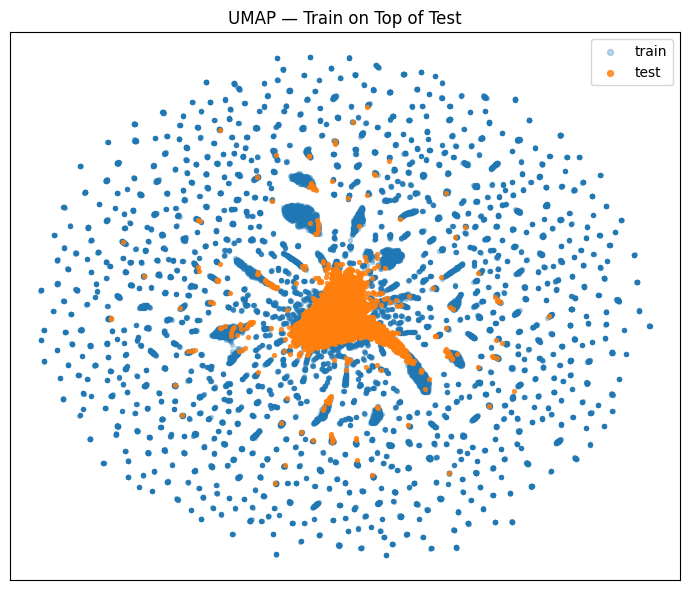

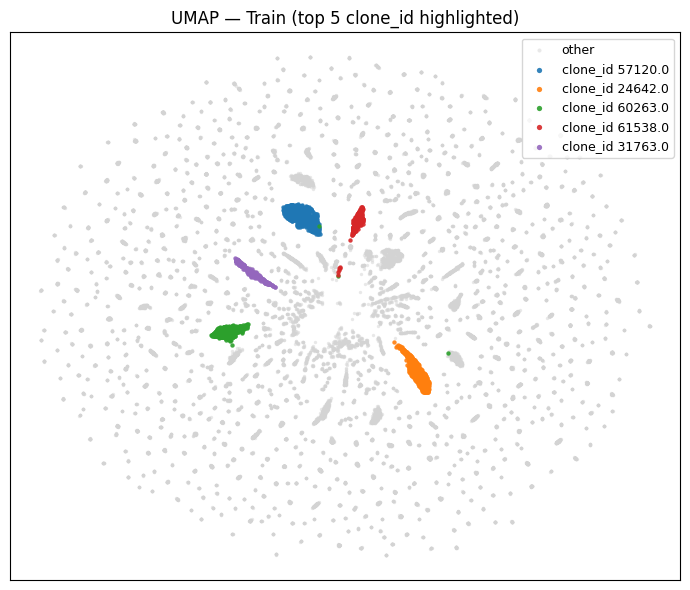

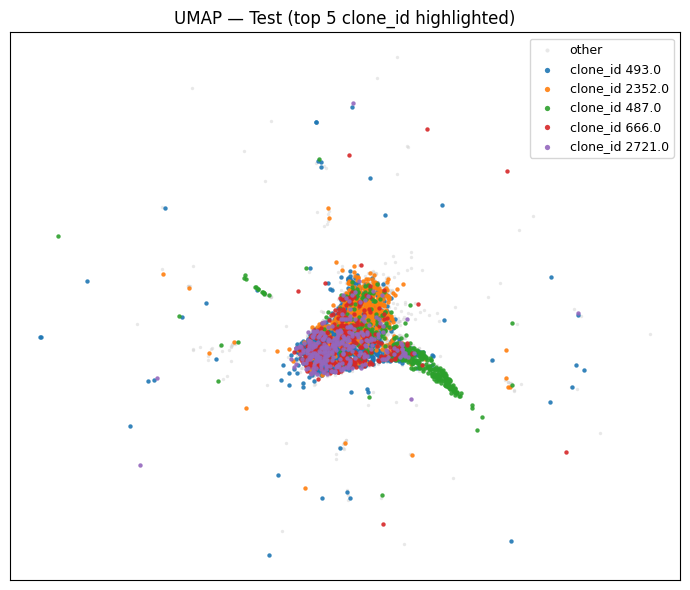

In [14]:
plot_train_test_umap(emb2d_train_001_5, emb2d_test_001_5)
plot_top5_umap(emb2d_train_001_5, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_5,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

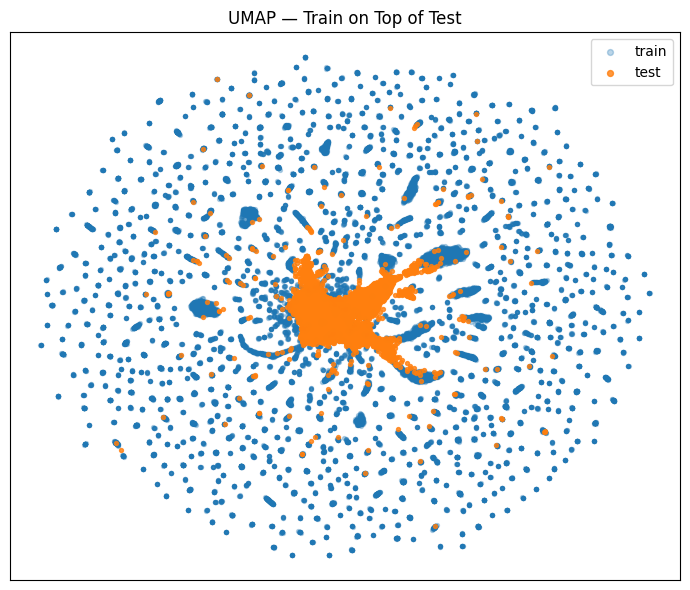

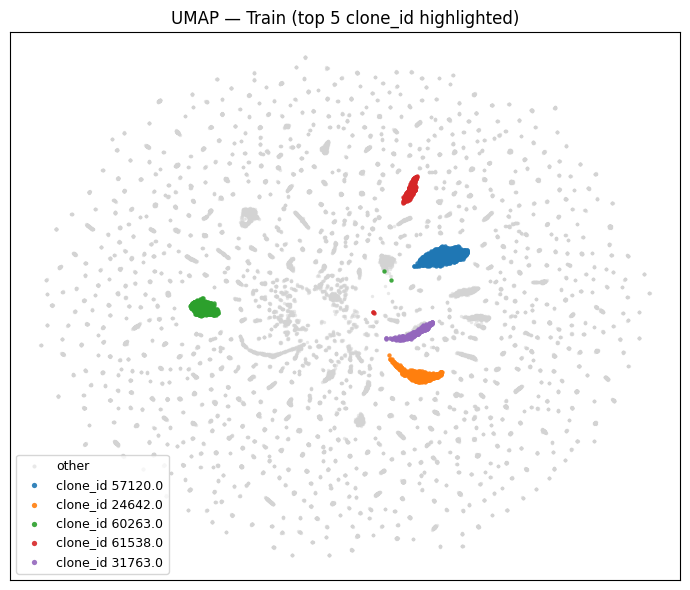

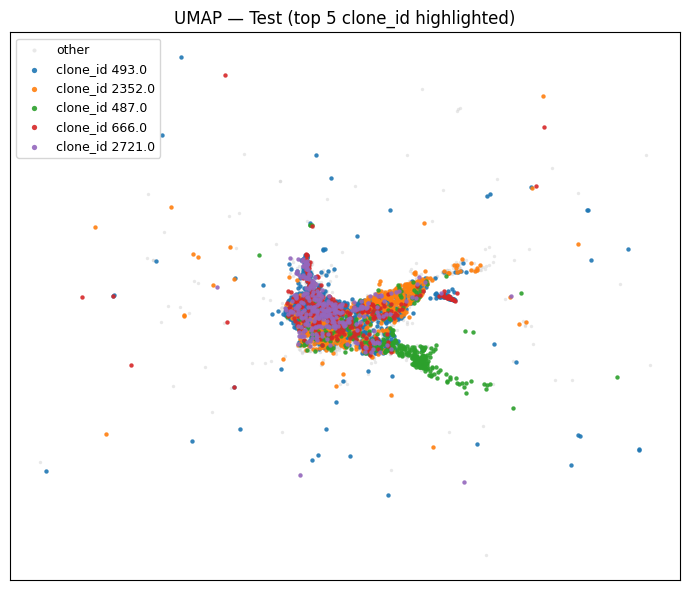

In [15]:
plot_train_test_umap(emb2d_train_001_15, emb2d_test_001_15)
plot_top5_umap(emb2d_train_001_15, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_15,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

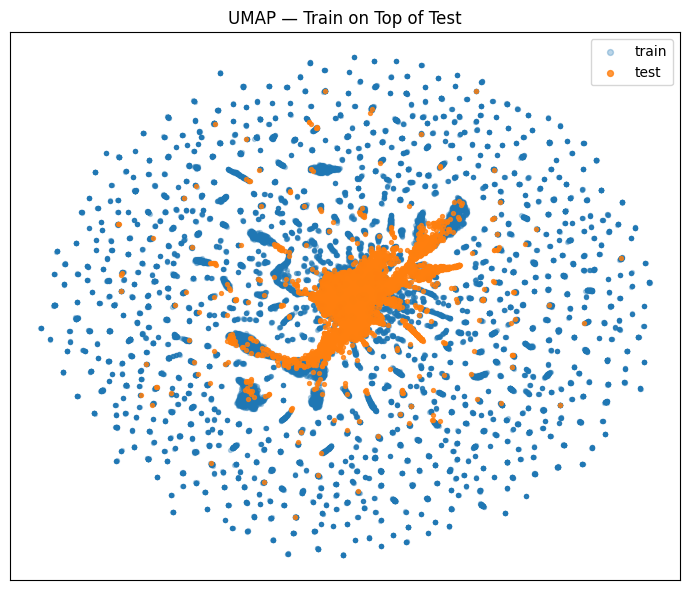

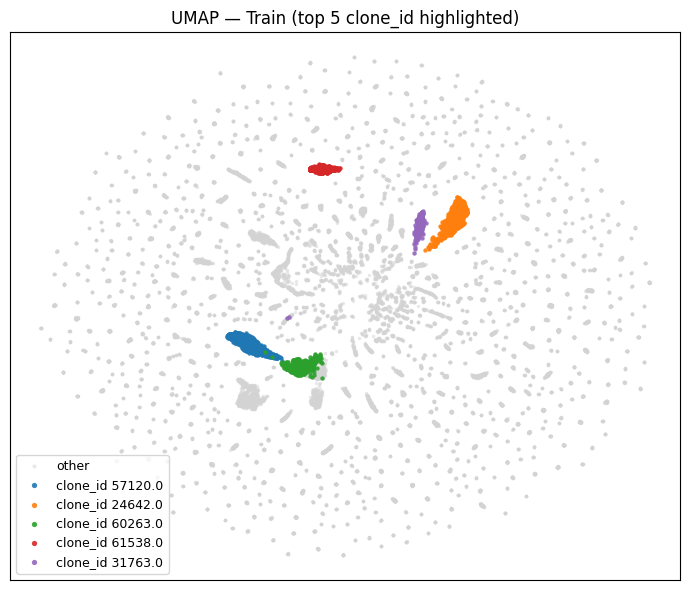

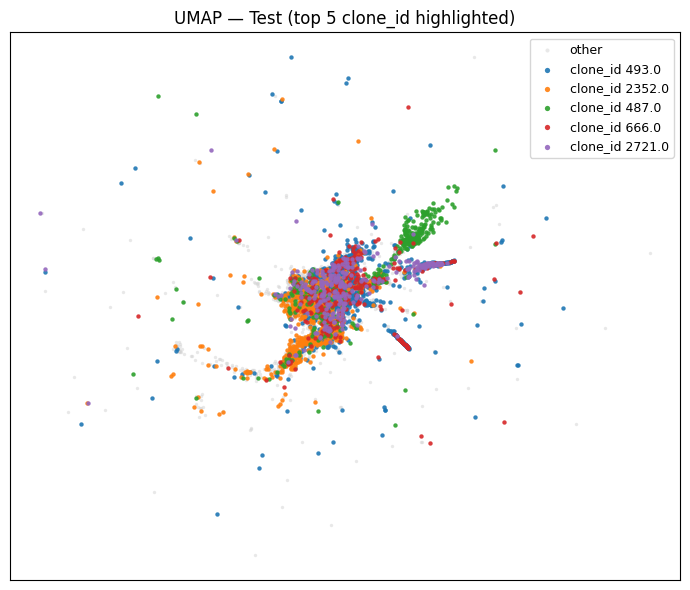

In [16]:
plot_train_test_umap(emb2d_train_001_25, emb2d_test_001_25)
plot_top5_umap(emb2d_train_001_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

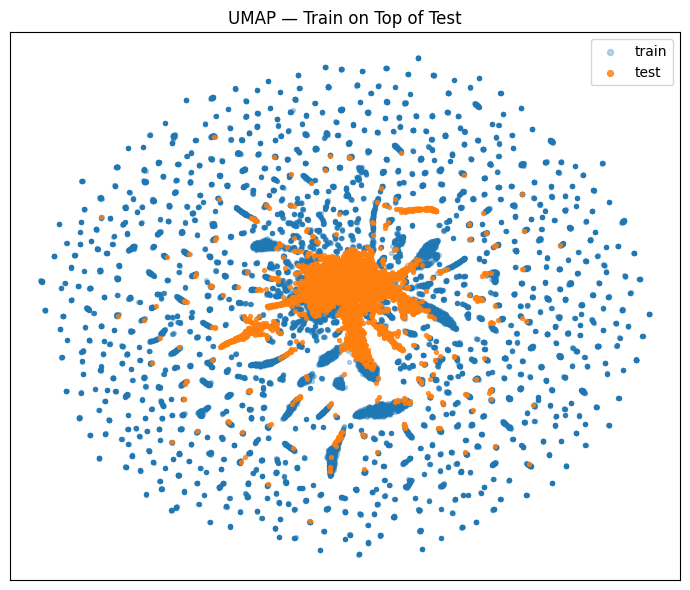

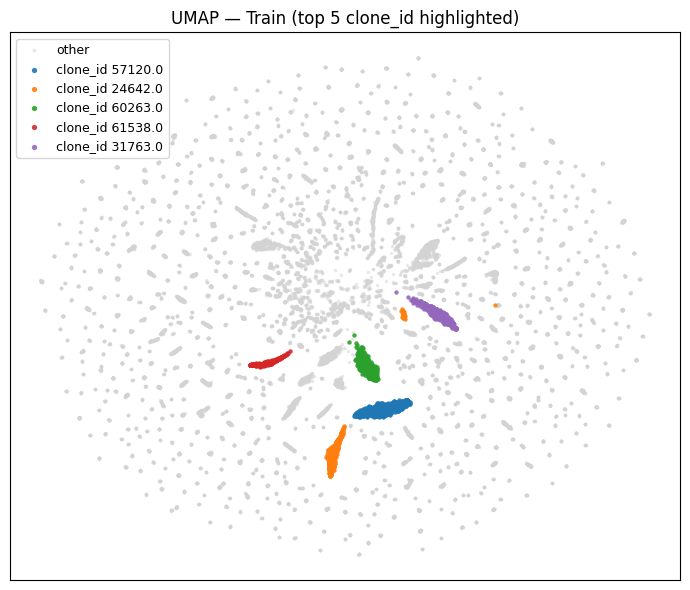

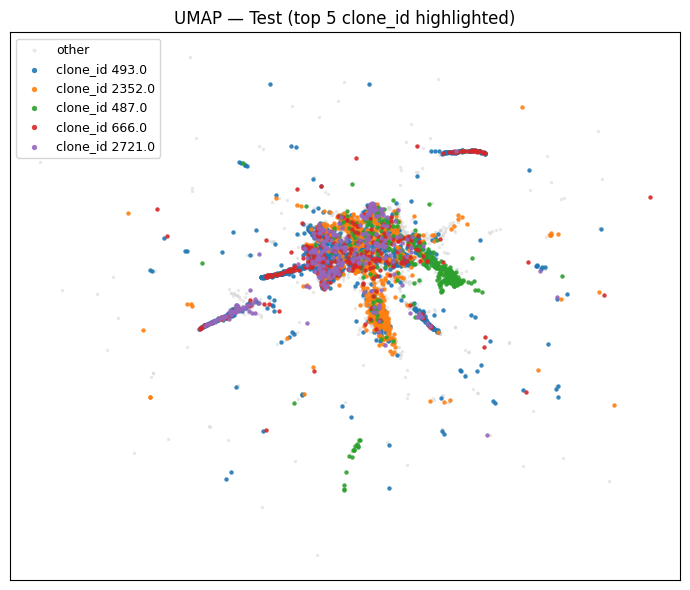

In [17]:
plot_train_test_umap(emb2d_train_001_50, emb2d_test_001_50)
plot_top5_umap(emb2d_train_001_50, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_50,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

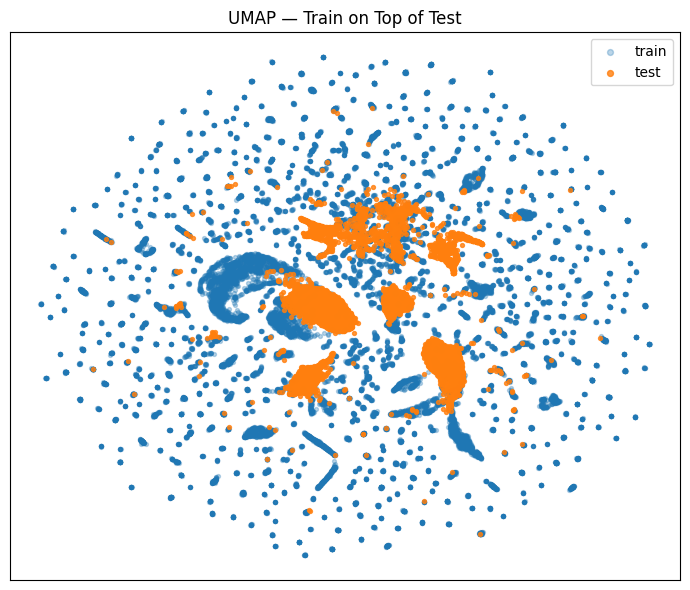

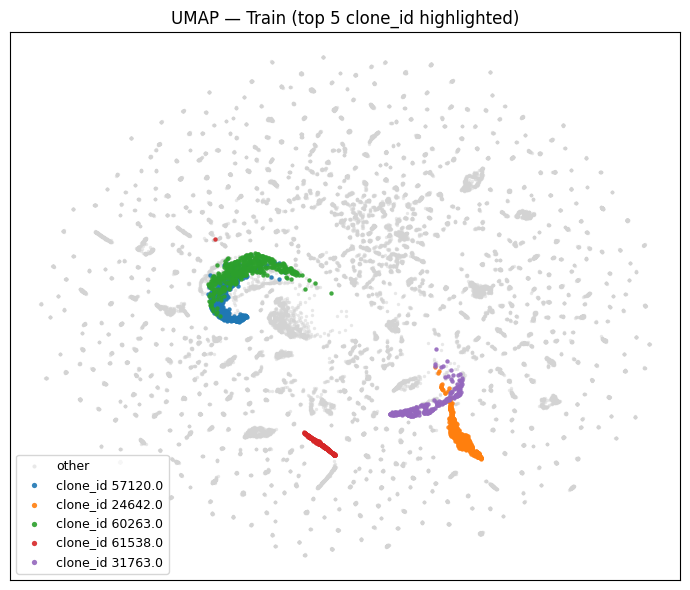

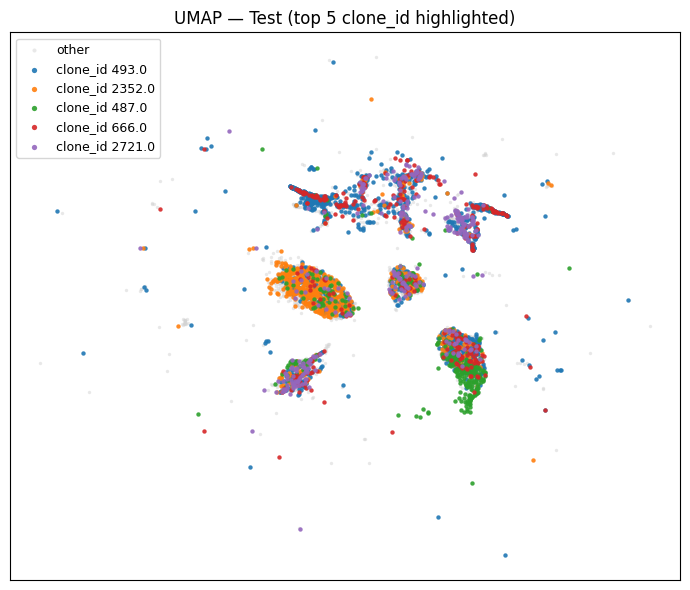

In [18]:
plot_train_test_umap(emb2d_train_005_50, emb2d_test_005_50)
plot_top5_umap(emb2d_train_005_50, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_005_50,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

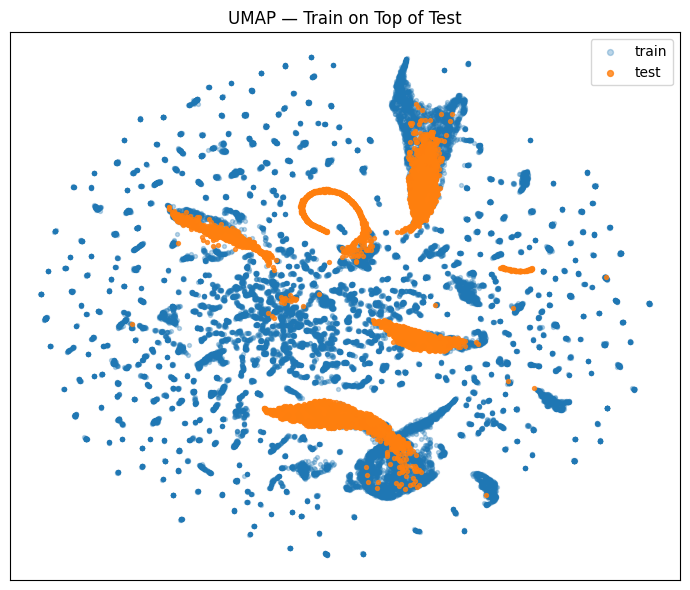

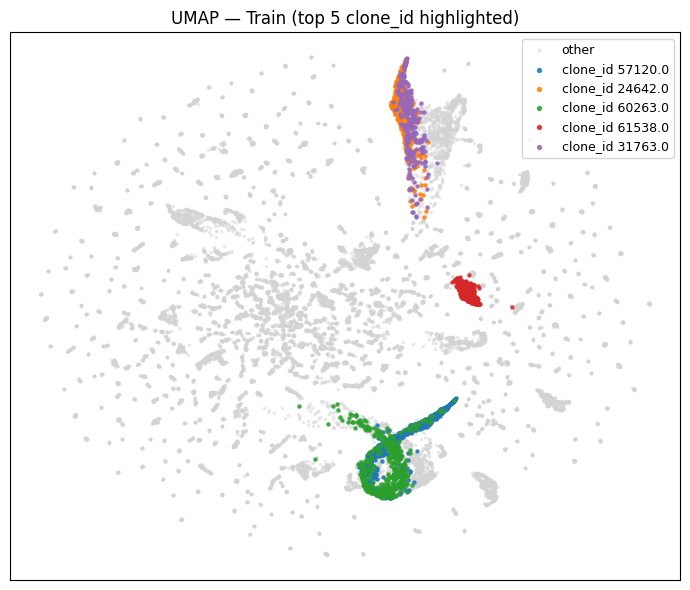

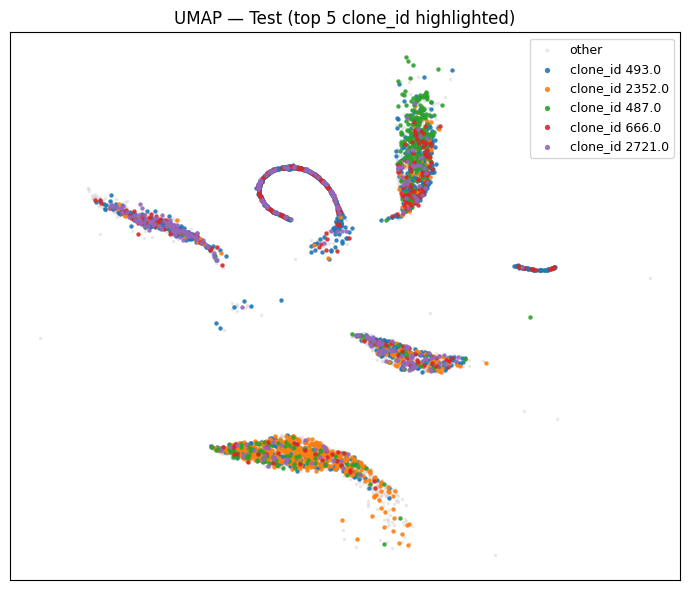

In [19]:
plot_train_test_umap(emb2d_train_01_25, emb2d_test_01_25)
plot_top5_umap(emb2d_train_01_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_01_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

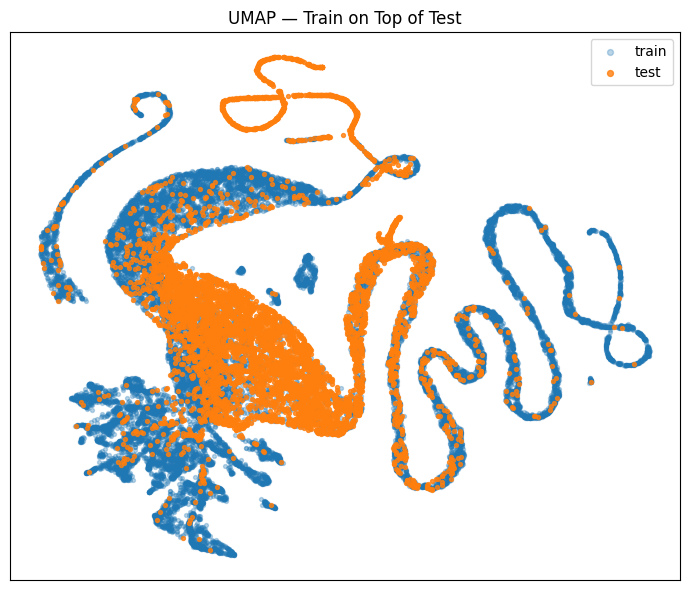

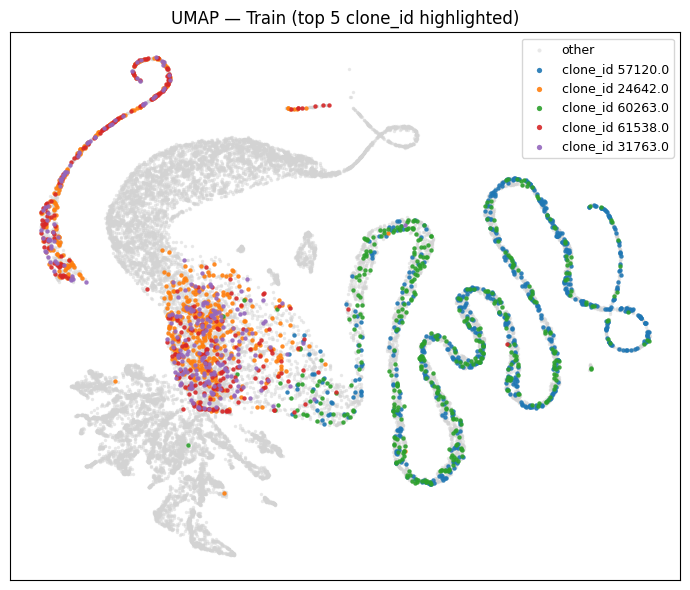

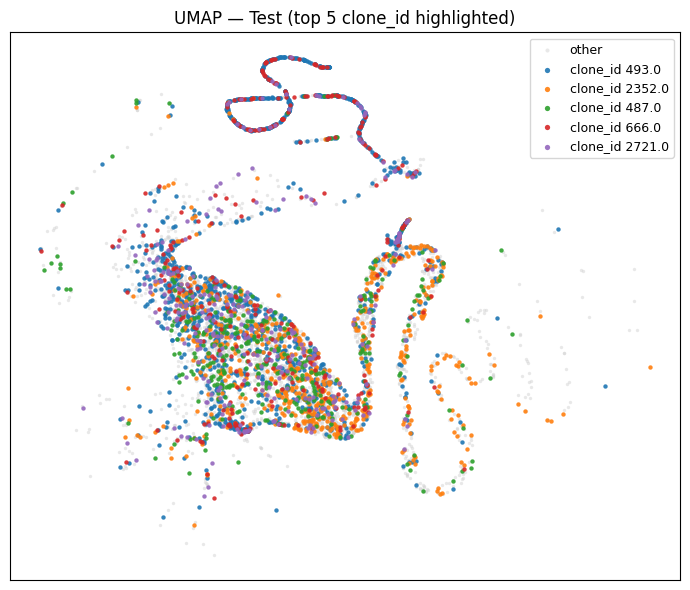

In [20]:
plot_train_test_umap(emb2d_train_1_25, emb2d_test_1_25)
plot_top5_umap(emb2d_train_1_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_1_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

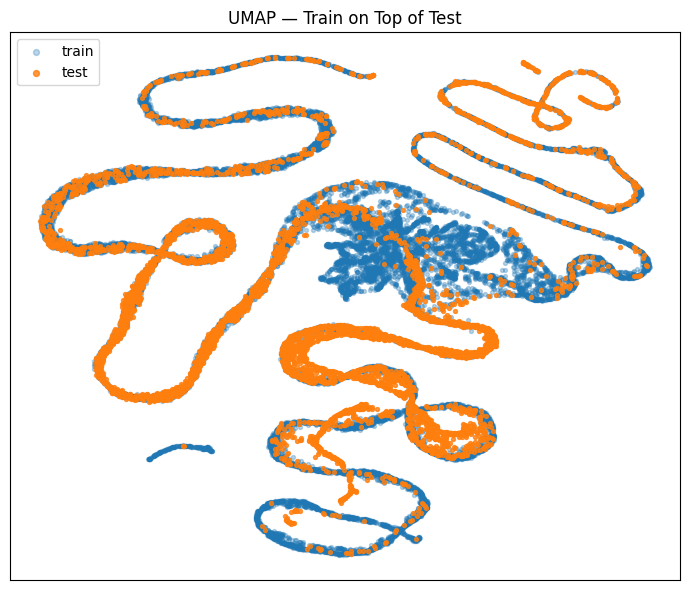

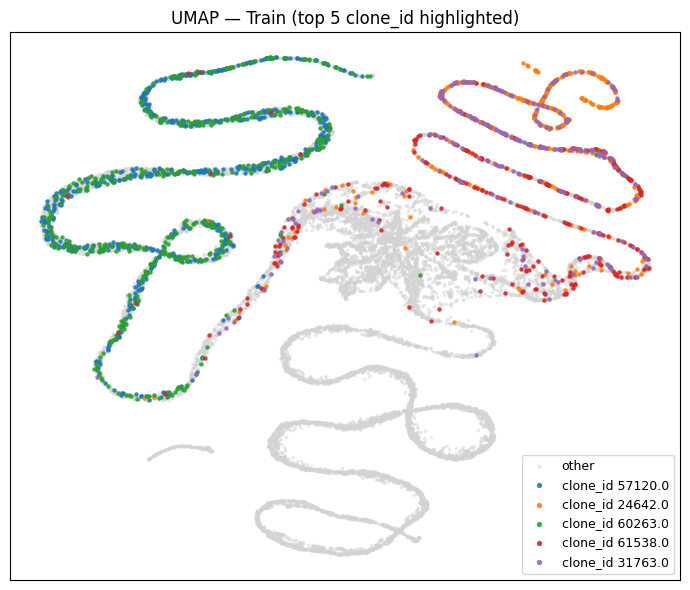

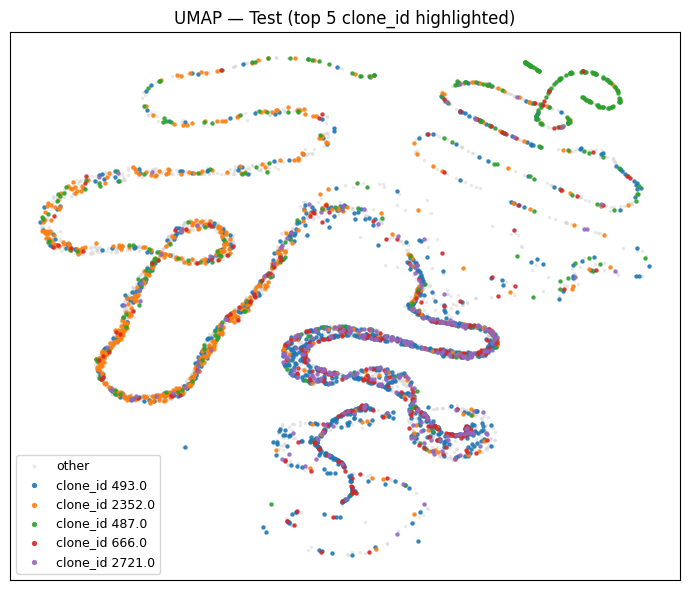

In [21]:
plot_train_test_umap(emb2d_train_2_25, emb2d_test_2_25)
plot_top5_umap(emb2d_train_2_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_2_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

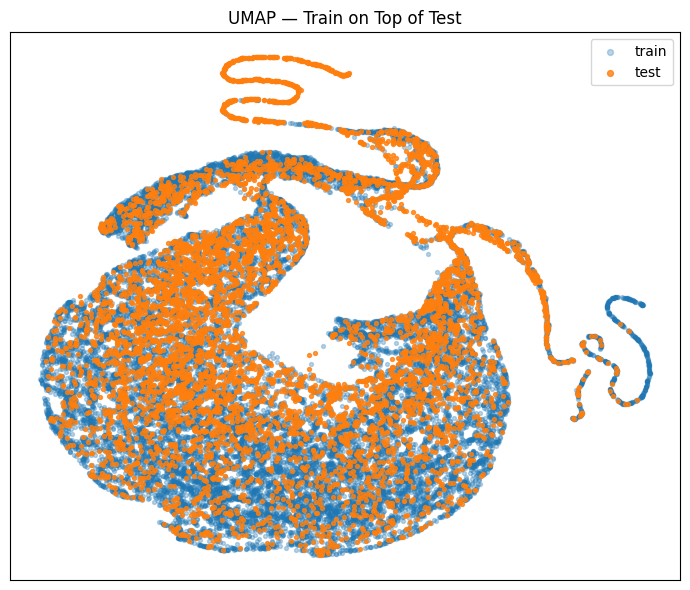

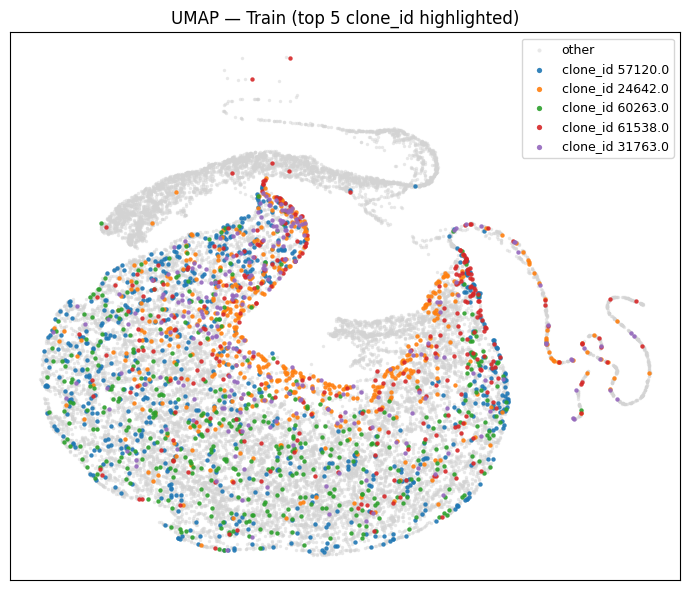

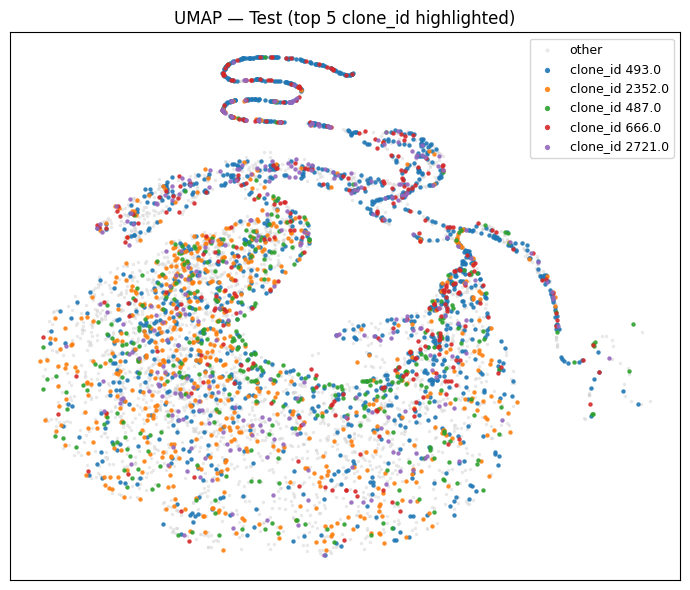

In [22]:
plot_train_test_umap(emb2d_train_10_25, emb2d_test_10_25)
plot_top5_umap(emb2d_train_10_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_10_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")